# Detecting Insults in Social Commentary

### Problem Definition:
__________________
The challenge is to detect if a comment from an online conversation can be considered insulting to another participant in the conversation. The idea is to create a generalizable single-class classifier which could operate in a near real-time mode. In this project I build a system that can detect whether or not any given comment is insulting by building a machine learning system.

In addition to just building a classifier this project also test different classifier - **Linear & Non-Linear** and decide which might be the best classifier for the purpose.


Ref: https://www.kaggle.com/c/detecting-insults-in-social-commentary

Ref: http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

In [104]:
import numpy as np
import pandas as pd
import sklearn
# to split data
import sklearn.feature_extraction.text as text
from sklearn.model_selection import train_test_split as cv

In [2]:
# Support Vector machine
from sklearn import svm
# Naive Bayes
import sklearn.naive_bayes as nb
# Logistic Regression
from sklearn.linear_model import LogisticRegression
# decision tree
from sklearn.tree import DecisionTreeClassifier
# random forest 
from sklearn.ensemble import RandomForestClassifier

## I. Data Ingestion
In this stage data for training and testing is obtained from Kaggle. Training dataset contains **3947** examples, each of which consists of the text of a particular post and its desired label. Test dataset contains **2235** examples. Data is also inspected for shape and features.

A label of 1 represents an insulting post, while a label of 0 represents a non-insulting post. For Example, 

**Text:** “You’re a moron, truth is beyond your reach”, **Label: 1**

**Text:** “I’ll take that temp…I really hate the heat”, **Label: 0**

#### Loading and preparing the data

In [3]:
# Open the training file with pandas.
df = pd.read_csv("data/train.csv")
# Open the test file with pandas.
df_test = pd.read_csv("data/test.csv")

In [4]:
# Inspect complete dataset
df.head(5)

,Insult,Date,Comment
0,1,20120618192155Z,"""You fuck your dad."""
1,0,20120528192215Z,"""i really don't understand your point.\xa0 It ..."
2,0,NaN,"""A\\xc2\\xa0majority of Canadians can and has ..."
3,0,NaN,"""listen if you dont wanna get married to a man..."
4,0,20120619094753Z,"""C\xe1c b\u1ea1n xu\u1ed1ng \u0111\u01b0\u1edd..."


In [5]:
# Inspecting test dataset
df_test.head(5)

,id,Date,Comment
0,1,20120603163526Z,"""like this if you are a tribe fan"""
1,2,20120531215447Z,"""you're idiot......................."""
2,3,20120823164228Z,"""I am a woman Babs, and the only ""war on women..."
3,4,20120826010752Z,"""WOW & YOU BENEFITTED SO MANY WINS THIS YEAR F..."
4,5,20120602223825Z,"""haha green me red you now loser whos winning ..."


In [6]:
# getting the shape of dataframe
df.shape, df_test.shape

((3947, 3), (2235, 3))

In [7]:
# Getting the Count of Positive and Negative
df[['Comment','Insult']].groupby('Insult').count()

,Comment
Insult,
0,2898
1,1049


In total, **1049** of the examples are labelled as **“insulting”**, while the remaining **2898** examples are labelled as **“not insulting”**.

In [8]:
# Inspect data
df[['Insult', 'Comment']].tail(5)

,Insult,Comment
3942,1,"""you are both morons and that is never happening"""
3943,0,"""Many toolbars include spell check, like Yahoo..."
3944,0,"""@LambeauOrWrigley\xa0\xa0@K.Moss\xa0\nSioux F..."
3945,0,"""How about Felix? He is sure turning into one ..."
3946,0,"""You're all upset, defending this hipster band..."


In [9]:
# splitting Labels and comments
label, comments, comments_test = df['Insult'],df['Comment'], df_test['Comment']

#### Note: merging two dataframes - df[Comment] & df_test[Comment]
Reason - ValueError: X has 5943(df_test['Comment']) features per sample; expecting 11796 (df['Comment'])
This is because of the differnece in number of feature classifier is built on
Than features used to test classifier

In [10]:
# Shape
comments.shape, comments_test.shape

((3947,), (2235,))

In [11]:
comments_large=pd.concat([comments,comments_test])
# checking label, comments
type(label), type(comments_large), comments_large.shape

(pandas.core.series.Series, pandas.core.series.Series, (6182,))

## II. Data Wrangling

Once the data has been loaded, data wrangling pipeline is being created to clean data and remove garbage characters. 

1. Text Cleansing.
2. Tokenization
3. Stemming
4. Lemmatization
5. Stop words removal

In [12]:
from nltk import sent_tokenize
import re
from re import sub
import string
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer

#### Text Cleaning: Removing Stopwords

In [14]:
import nltk
from nltk.corpus import stopwords
stopWords = set(stopwords.words('english'))

####  Text Cleaning: To Lower Case

In [15]:
def to_lower_case(data):
    data=data.str.lower()
    data.iloc[5]

#### Text Cleaning: Removing special characters

In [16]:
def remove_special_char(x):
    # this will replace all punctuations with spaces
    punc = string.punctuation.replace("-", "")
    punc = punc.replace("'", "")
    pat= r"[{}]".format(punc)
    x=re.sub(pat, " ", x)
    
    # this will replace all digits with None
    x=re.sub(pattern=r"\d", repl=r" ", string=x)
    # this will strip extra white spaces
    return " ".join( i for i in stemming(x))

#### Text Cleaning: Stemming and Lemmatization

In [17]:
def stemming(x):
    # Lemmatize
    st = WordNetLemmatizer()
    words=x.strip().split()
    # stemming words
    st3=SnowballStemmer("english")
    return [st3.stem(st.lemmatize(x)) for x in words]

#### Text Cleaning: Tokenization

In [18]:
def tokenize(data):
    tf = text.TfidfVectorizer(stop_words=stopWords, ngram_range=(1, 1))
    X = tf.fit_transform(data)
    print("shape of sparse matrix", X.shape)
    return X

In [18]:
# this is experimental tokenizer with ngram features
# tf = text.TfidfVectorizer(stop_words=stopWords,ngram_range=(1, 5))

#### Kicking off Data Wrangling

In [19]:
def data_cleaning(data):
    #making a copy of transformed 
    to_lower_case(data)
    transformed = data.apply(remove_special_char)
    print("\nTransformation:", data.iloc[1], transformed.iloc[1])
    
    # checking sparsity of matrix
    X=tokenize(transformed)
    print("Each sample has ~{0:.2%} non-zero features.".format(X.nnz / float(X.shape[0] * X.shape[1])))
    return X

In [20]:
# Clean training Comments
comments_large_cleaned=data_cleaning(comments_large)
type(comments_large_cleaned)


Transformation: "i really don't understand your point.\xa0 It seems that you are mixing apples and oranges." i realli don't understand your point \xa it seem that you are mix appl and orang
shape of sparse matrix (6182, 14180)
Each sample has ~0.10% non-zero features.


scipy.sparse.csr.csr_matrix

#### Splitting Training and Testing Datasets

In [25]:
from scipy import sparse
# expanding matrix
temp=comments_large_cleaned.todense()

# splitting the data
comments_training,comments_testing=temp[:3947],temp[3947:]

# converting to sparse matrix
X_training,X_testing=sparse.csr_matrix(comments_training),sparse.csr_matrix(comments_testing)

# inspecting the transformed data
type(X_training),type(X_testing), X_training.shape, X_testing.shape

(scipy.sparse.csr.csr_matrix,
 scipy.sparse.csr.csr_matrix,
 (3947, 14180),
 (2235, 14180))

# III. Building Model

First I will use linear classification models **Naïve Bayes, SVMs, and Logistic Regression** for building the classifier as they are very common and easy models for classification. 

Following this I will build Non-Linear classifiers  like **Random Forest Classifier, Decision Tree Classifier**.

#### Preparing Training Data - 80:20 (Train and Validation)

In [26]:
(X_train, X_val,label_train, label_val) = cv(X_training, label, test_size=.2)
# investigating the shape of data
X_train.shape, X_val.shape, label_train.shape, label_val.shape

((3157, 14180), (790, 14180), (3157,), (790,))

### Linear Classification Models

### 1. Logistic Regression (LR)

ref: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [37]:
def model_LR():
    # building classifier
    clf = LogisticRegression(tol=1e-8, penalty='l2', C=2)
    # training classifier
    clf.fit(X_train, label_train)
    print("Model: ",type(clf))
    # Predicting probabilities
    p = clf.predict_proba(X_val)
    return (clf.predict(X_val),p,clf)

### 2. Support Vector Machine (SVM)

ref: http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC

In [53]:
def model_SVM():
    # building classifier
    clf = svm.LinearSVC(penalty='l2', loss='squared_hinge',tol=1e-8)
    # training classifier
    clf.fit(X_train, label_train)
    # model type
    print("Model: ",type(clf))
    return (clf.predict(X_val),clf)

### 3. Naive Bayes (NB)
Bernoulli Naive Baiyes (ref: http://scikit-learn.org/stable/modules/naive_bayes.html#naive-bayes)

In [54]:
def model_BernoulliNB():
    # creating classifier
    clf = nb.BernoulliNB(alpha=1.0, binarize=0.0)
    # training classifier
    clf.fit(X_train, label_train)
    # model type
    print("Model: ",type(clf))
    # Predicting probabilities
    p = clf.predict_proba(X_val)
    return (clf.predict(X_val),p,clf)

### Non-Linear Classification Models


### 1. Random Forest Classifier

In [55]:
def model_RF():
    # creating classifier
    clf = RandomForestClassifier(n_estimators=100)
    # training classifier
    clf.fit(X_train, label_train)
    # model type
    print("Model: ",type(clf))
    # Predicting probabilities
    p = clf.predict_proba(X_val)
    return (clf.predict(X_val),p,clf)

### 2. Decision Tree Classifier (DT)

In [56]:
def model_DT():
    # creating classifier
    clf = DecisionTreeClassifier(max_depth=100)
    # training classifier
    clf.fit(X_train, label_train)
    # model type
    print("Model: ",type(clf))
    # Predicting probabilities
    p = clf.predict_proba(X_val)
    return (clf.predict(X_val),p,clf)

# IV. Model Evaluation

The primary evaluation metrics that I have used on my system training are **accuracy and 10-fold cross validation**. I used the training accuracy to determine how well the model is fitting in training data and testing with validation data. The cross validation accuracy was more significant because it was more generalized.

In [41]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score as auc_score

In [31]:
def model_evaluation(model,label_test):
    # confusion matrix:
    cm = confusion_matrix(label_test, model, labels=None, sample_weight=None)
    # true positive(tp) / false negative(fn) / false positive(fp) / true negaive(tn)
    tp, fn, fp, tn = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    # precision
    precision= float(tp)/(tp+fp)
    # recall
    recall =  float(tp)/(tp+tn)
    # accuracy
    accuracy = np.mean(model == label_test)
    
    # print results
    print_results (precision, recall, accuracy)    
    # plot the curve
    plot_roc_graph(model,label_test)
    # return accuracy, precision, recall values
    return accuracy,precision,recall

In [34]:
def print_results (precision, recall, accuracy):
    banner = "Here is the classification report"
    print ('\n',banner)
    print ('=' * len(banner))
    print ('{0:10s} {1:.1f}'.format('Precision',precision*100))
    print ('{0:10s} {1:.1f}'.format('Recall',recall*100))
    print ('{0:10s} {1:.1f}'.format('Accuracy',accuracy*100))

In [42]:
def plot_roc_graph(label_predicted,label_test):
    # Plot ROC Curve
    fpr, tpr, _ = metrics.roc_curve(label_test,label_predicted)
    # calculate AUC score
    auc = auc_score(label_test, label_predicted)
    plt.plot(fpr,tpr,label="data, auc="+str(auc))
    plt.legend(loc=4)
    plt.show()

## Accuracy, Precision, Recall

In [48]:
# List of all Models
all_models=[]
# List of all predictions
all_predictions=[]
# Precision Recall
all_precision=[]
all_recall=[]
# List of all model accuracy
accuracy_normal=[]

#### Logistic Regression

Model:  <class 'sklearn.linear_model.logistic.LogisticRegression'>

 Here is the classification report
Precision  83.7
Recall     88.7
Accuracy   83.7


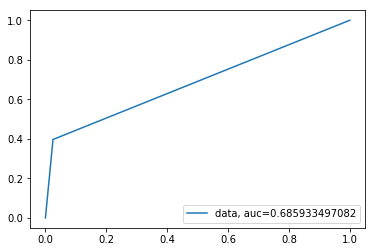

AUC Score  87.2


In [50]:
# model prediction
clf_LR, p, model_lr = model_LR()
all_models.append(model_lr)
all_predictions.append(clf_LR)

# model evaluation
(acc_LR,p_LR,r_LR) = model_evaluation(clf_LR, label_val)
print ('{0:10s} {1:.1f}'.format('AUC Score',auc_score(label_val, p[:,1])*100))
accuracy_normal.append(round(acc_LR*100,2))
all_precision.append(p_LR)
all_recall.append(r_LR)

#### Support Vector Machine

Model:  <class 'sklearn.svm.classes.LinearSVC'>

 Here is the classification report
Precision  86.1
Recall     85.2
Accuracy   83.5


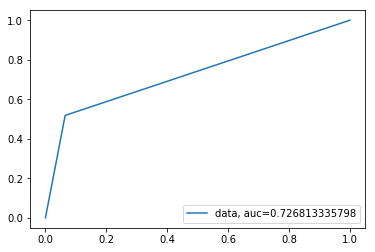

In [57]:
# model prediction
clf_SVM,model_svm = model_SVM()
all_models.append(model_svm)
all_predictions.append(clf_SVM)

# model evaluation
(acc_SVM, p_SVM, r_SVM) = model_evaluation(clf_SVM, label_val)
accuracy_normal.append(round(acc_SVM*100,2))
all_precision.append(p_SVM)
all_recall.append(r_SVM)

#### Naive Bayes

Model:  <class 'sklearn.naive_bayes.BernoulliNB'>

 Here is the classification report
Precision  78.2
Recall     95.7
Accuracy   77.2


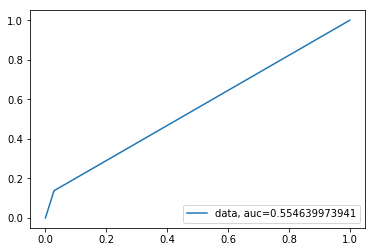

AUC Score  81.0


In [58]:
# model prediction
clf_NB,p,model_nb=model_BernoulliNB()
all_models.append(model_nb)
all_predictions.append(clf_NB)

# model evaluation
(acc_NB,p_NB,r_NB) = model_evaluation(clf_NB, label_val)
print ('{0:10s} {1:.1f}'.format('AUC Score',auc_score(label_val, p[:,1])*100))
accuracy_normal.append(round(acc_NB*100,2))
all_precision.append(p_NB)
all_recall.append(r_NB)

#### Random Forest

Model:  <class 'sklearn.ensemble.forest.RandomForestClassifier'>

 Here is the classification report
Precision  84.0
Recall     88.2
Accuracy   83.5


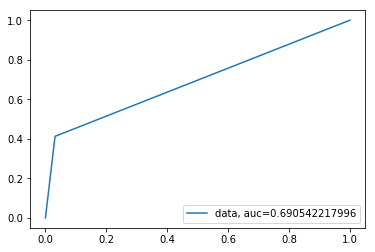

AUC Score  85.2


In [59]:
# model prediction
clf_RF,p,model_rf=model_RF()
all_models.append(model_rf)
all_predictions.append(clf_RF)

# model evaluation
(acc_RF,p_RF,r_RF) = model_evaluation(clf_RF, label_val)
print ('{0:10s} {1:.1f}'.format('AUC Score',auc_score(label_val, p[:,1])*100))
accuracy_normal.append(round(acc_RF*100,2))
all_precision.append(p_RF)
all_recall.append(p_RF)

#### Decision Tree

Model:  <class 'sklearn.tree.tree.DecisionTreeClassifier'>

 Here is the classification report
Precision  86.1
Recall     83.8
Accuracy   80.4


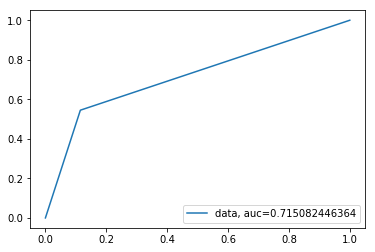

AUC Score  66.4


In [60]:
# model prediction
clf_DT,p,model_dt=model_DT()
all_models.append(model_dt)
all_predictions.append(clf_DT)

# model evaluation
(acc_DT, p_DT, r_DT)= model_evaluation(clf_DT, label_val)
print ('{0:10s} {1:.1f}'.format('AUC Score',auc_score(label_val, p[:,1])*100))
accuracy_normal.append(round((acc_DT*100),2))
all_precision.append(p_DT)
all_recall.append(r_DT)

## Accuracy : K-Fold Cross Validation

In [61]:
# Logistic Regression
clf1 = LogisticRegression(tol=1e-8, penalty='l2', C=2)
# Support Vector Machines
clf2 = svm.LinearSVC(penalty='l2', loss='squared_hinge')
# Naive Bayes
clf3 = nb.BernoulliNB(alpha=1.0, binarize=0.0)
# Random Forest
clf4 = RandomForestClassifier(n_estimators=100)
# Decision Tree
clf5 = DecisionTreeClassifier(max_depth=100)
created_models=[clf1, clf2, clf3, clf4, clf5]

In [62]:
def k_fold_validation(data, kFolds):
    # Accuracy after cross validation:
    accuracy_cv=[]
    for clf in created_models:
        accuracy_common=0
        for test_run in range(kFolds):
            (X_train, X_test, y_train, y_test) = cv(X_training, label, test_size=.2)
            # fit classifier
            clf.fit(X_train, y_train)
            # predict 
            model=clf.predict(X_test)
            # compare result
            accuracy=np.mean(model == y_test)
            # append to common
            accuracy_common += accuracy
        # add to list of accuracy 
        accuracy_cv.append(float(accuracy_common)/10*100)
    return accuracy_cv

In [63]:
# Number of Folds
n_Folds = 10
# perform k-cross validation
accuracy_cv=k_fold_validation(X_training,n_Folds)
accuracy_cv=[round(float(i),2) for i in accuracy_cv]

accuracy_normal=[round(float(i),2) for i in accuracy_normal]

print("Normal Accuracy")
print("================")
print(accuracy_normal)
print("\nAccuracy post CV")
print("================")
print(accuracy_cv)

Normal Accuracy
[83.67, 83.54, 77.22, 83.54, 80.38]

Accuracy post CV
[82.41, 82.71, 74.41, 82.23, 79.48]


# V. Results

With all of the above features and techniques implemented, a cross-validation accuracy of 82.8% was achieved for **Support Vector Machine** Classifier. This was followed by **Random Forest Classifier and Logistic Regression** Respectively.

Following diagrams will visually represent the results gained after Cross Validation.

In [79]:
import seaborn as sns
import warnings
import matplotlib.pyplot as plt; plt.rcdefaults()
%matplotlib inline
# set plot size
fig_size=[7,5]
#fig_size[0],fig_size[1] = 8,6
plt.rcParams["figure.figsize"] = fig_size
# Labels on graph
labels = training_df['Technique']
# Setting the positions and width for the bars
x_pos = list(range(len(training_df["Technique"])))
width = 0.25 

### A. Normal vs CrossValidation Accuracy Scores 

In [76]:
raw_data = {'Technique': ['LogisticRegression', 'SVM', 'NaiveBayes', 'RandomForest', 'DecisionTree'],
            'Normal_Accuracy': accuracy_normal,
            'Cross_Validation': accuracy_cv
           }
training_df = pd.DataFrame(raw_data, columns = ['Technique', 'Normal_Accuracy', 'Cross_Validation'])
training_df

,Technique,Normal_Accuracy,Cross_Validation
0,LogisticRegression,83.67,82.41
1,SVM,83.54,82.71
2,NaiveBayes,77.22,74.41
3,RandomForest,83.54,82.23
4,DecisionTree,80.38,79.48


#### Model Evaluation: Basic Accuracy

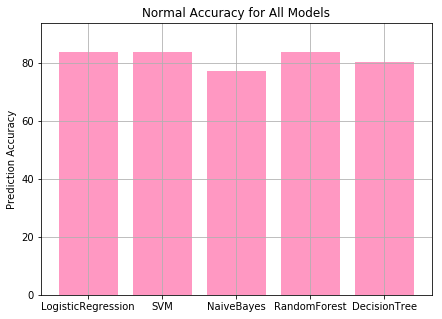

In [103]:
# ref: https://chrisalbon.com/python/matplotlib_bar_plot.html
plt.bar(x_pos,training_df["Normal_Accuracy"], align='center', color='#FF3386',alpha=0.5)
# add a grid
plt.grid()
# set height of the y-axis
max_y = max(training_df["Normal_Accuracy"])+10
plt.ylim([0, max_y])
# set axes labels and title
plt.ylabel('Prediction Accuracy')
plt.xticks(x_pos, labels)
plt.title('Normal Accuracy for All Models')

#### Model Evaluation: Cross Validation

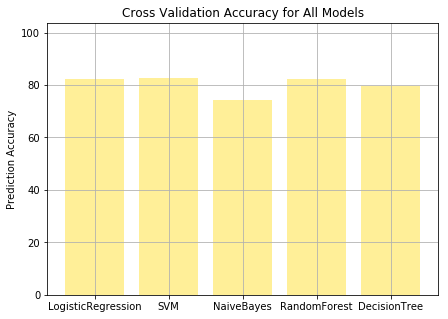

In [102]:
# ref: https://chrisalbon.com/python/matplotlib_bar_plot.html
plt.bar(x_pos,training_df["Cross_Validation"], align='center', color='#FFE033',alpha=0.5)
# add a grid
plt.grid()
# set height of the y-axis
max_y = max(training_df["Normal_Accuracy"])+20
plt.ylim([0, max_y])

# set axes labels and title
plt.ylabel('Prediction Accuracy')
plt.xticks(x_pos, labels)
plt.title('Cross Validation Accuracy for All Models')
plt.show()

#### Comparing  Accuracies - CV vs Normal

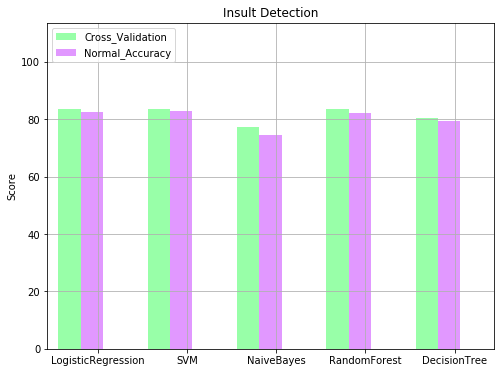

In [92]:
# Setting the positions and width for the bars
pos = list(range(len(training_df['Technique']))) 
width = 0.25 
# Plotting the bars
fig, ax = plt.subplots(figsize=(8,6))

# Create a bar for RMSE vs MAE,
# ref: https://chrisalbon.com/python/matplotlib_grouped_bar_plot.html
plt.bar(pos, training_df['Normal_Accuracy'], width,alpha=0.5, color='#33FF52',label=training_df['Technique'][0]) 
plt.bar([p + width for p in pos], training_df['Cross_Validation'], width, alpha=0.5, color='#C433FF', label=training_df['Technique'][2])

# Set the y axis label
ax.set_ylabel('Score')
# Set the chart's title
ax.set_title('Insult Detection')

# Set the position of the x ticks
ax.set_xticks([p + 1.25 * width for p in pos])
# Set the labels for the x ticks
ax.set_xticklabels(training_df['Technique'])

# Setting the x-axis and y-axis limits
plt.xlim(min(pos)-width, max(pos)+width*3)
plt.ylim([0, max(training_df['Normal_Accuracy'])+30] )

# Adding the legend and showing the plot
plt.legend(['Cross_Validation','Normal_Accuracy'], loc='upper left')
plt.grid()
plt.show()

### Comparing Precision Recall Values

In [83]:
all_recall=[round(float(i),2) for i in all_recall]
all_precision=[round(float(i),2) for i in all_precision]
# precision-recall data
pr_data = {'Technique': ['LogisticRegression', 'SVM', 'NaiveBayes', 'RandomForest', 'DecisionTree'],
            'Precision': all_precision,
            'Recall': all_recall
           }
pr_df = pd.DataFrame(pr_data, columns = ['Technique', 'Precision', 'Recall'])
pr_df

,Technique,Precision,Recall
0,LogisticRegression,84.0,89.0
1,SVM,86.0,85.0
2,NaiveBayes,78.0,96.0
3,RandomForest,84.0,84.0
4,DecisionTree,86.0,84.0


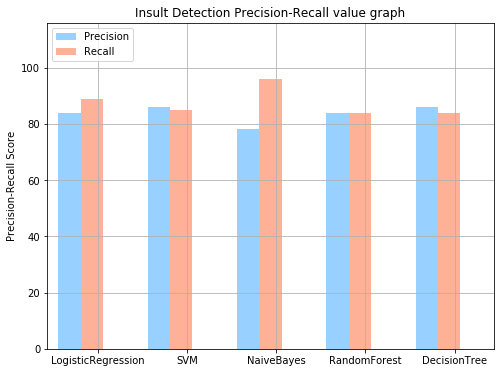

In [91]:
# Setting the positions and width for the bars
pos = list(range(len(pr_df['Technique']))) 
width = 0.25 
# Plotting the bars
fig, ax = plt.subplots(figsize=(8,6))

# Create a bar for RMSE vs MAE,
# ref: https://chrisalbon.com/python/matplotlib_grouped_bar_plot.html
plt.bar(pos, pr_df['Precision'], width,alpha=0.5, color='#33A2FF',label=training_df['Technique'][0]) 
plt.bar([p + width for p in pos], pr_df['Recall'], width, alpha=0.5, color='#FF6433', label=pr_df['Technique'][2])

# Set the y axis label
ax.set_ylabel('Precision-Recall Score')
# Set the chart's title
ax.set_title('Insult Detection Precision-Recall value graph')

# Set the position of the x ticks
ax.set_xticks([p + 1.25 * width for p in pos])
# Set the labels for the x ticks
ax.set_xticklabels(pr_df['Technique'])

# Setting the x-axis and y-axis limits
plt.xlim(min(pos)-width, max(pos)+width*3)
plt.ylim([0, max(pr_df['Precision'])+30] )

# Adding the legend and showing the plot
plt.legend(['Precision','Recall'], loc='upper left')
plt.grid()
plt.show()

### Validating Prediction Results

In [100]:
(comments_,comments_val) = cv(comments,test_size=.2)
validation_df = {'Comment':list(comments_val),
                 'TrueLabels':list(label_val),
                 'LogisticRegression': list(all_predictions[0]),
                 'SVM': list(all_predictions[1]),
                 'NaiveBayes': list(all_predictions[2]),
                 'RandomForest': list(all_predictions[3]),
                 'DecisionTree': list(all_predictions[4])}
val_results = pd.DataFrame(validation_df, columns = ['Comment','TrueLabels','LogisticRegression','SVM','NaiveBayes','RandomForest','DecisionTree'])

In [101]:
val_results.tail(20)

,Comment,TrueLabels,LogisticRegression,SVM,NaiveBayes,RandomForest,DecisionTree
770,"""Klein, you are a coward. Did you really inter...",1,0,0,0,1,1
771,"""You certainly are as 'right wing' as they com...",0,0,0,0,0,0
772,"""FOR SOME REASON U SOUND RETARDED. LOL. DAMN. ...",0,0,0,0,0,0
773,"""amen. you are true blue as usual.\xa0 G-D ble...",0,0,0,0,0,0
774,"""Pujols is gonna bomb this one to Center. Book...",0,0,0,0,1,1
775,"""You are a\xa0 really well-rounded idiot, aren...",0,0,0,0,0,1
776,"""@kevmille I haven't been to Sasebo. I visited...",0,0,0,0,0,0
777,"""I raze your pathetic Apple orchard to build m...",0,1,1,0,1,1
778,"""Been a while. Its because people would rather...",0,0,0,0,1,1
779,"""and retards like you back to the institutions.""",0,0,0,0,0,0


## VI. Predicting Test Data
In this section I will evaluate the prediction on test data.

In [93]:
# test comments
X_testing.shape, comments_test.iloc[5]

((2235, 14180),
 '"\\nMe and God both hate-faggots.\\n\\nWhat\'s the difference between a-fag-and a refrigerator?\\nRefrigerators don\'t fart when you put the meat in."')

### Testing Prediciton Against Each Model

In [94]:
def test_prediction(data):
    predicted_label=[]
    for model in all_models:
        #model.fit(data)
        predicted_label.append(list(model.predict(data)))
    return predicted_label

In [95]:
# generate predictions for test data
prediction_result=test_prediction(X_testing)

In [96]:
test_data = {'Comment':comments_test,
            'LogisticRegression': prediction_result[0],
            'SVM': prediction_result[1],
            'NaiveBayes': prediction_result[2],
            'RandomForest': prediction_result[3],
            'DecisionTree': prediction_result[4],
           }
results = pd.DataFrame(test_data, columns = ['Comment', 'LogisticRegression', 'SVM','NaiveBayes','RandomForest','DecisionTree'])

### Final Prediction Results 

In [99]:
results.tail(20)

,Comment,LogisticRegression,SVM,NaiveBayes,RandomForest,DecisionTree
2215,"""Who gives a fuck if it's a rental or not let ...",0,0,0,0,0
2216,"""Yes, you are. You don't need to point it out,...",0,0,0,0,0
2217,"""You're an idiot AND a spammer.\n\nIt's like i...",0,1,0,0,0
2218,"""You know what got thousands k illed it was Sa...",0,0,0,0,1
2219,"""I am a MM Fan but he was rather unfair to mos...",0,0,0,0,0
2220,"""When you are ready for this. Let me know. I...",0,0,0,0,0
2221,"""MENSAJE A PERIODICUCHOS INGLESES Y GRINGOS: F...",0,0,0,0,0
2222,"""_FUCK_YOU_NIGGER_LOVING_FAGGOT_GO_SWING_IN_TH...",1,1,0,1,1
2223,"""you are boring\n""",0,0,0,0,0
2224,"""By your comment.""",0,0,0,0,0


### Conclusion
In the end I conclude that **Random Forest** is the best classification model. This conclusion is based on following results - 
1. High Classification Accuracy - **83.5%**
2. High AUC Score - **85.2%**
3. Balance Precision / Recall values : **84%-84%**

Note: These results are specific to this project.